#### This code plots SessionData from LickToGetReward (2023-04-19)

In [1]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# set the working directory to the folder containing the .mat files
os.chdir('/Users/jun/Documents/Work/Project/Intralingual parasympathetic ganglion neurons/Behavior/ILPG_silencing_#1/Session_Data/')
# Load the original data
mat_contents = loadmat('ILPG_silencing#1_LickToGetReward_Training_20230414_145848_2023_04_18_Cue0_adjusted_data.mat')
SessionData = mat_contents['adjusted_SessionData']

In [2]:
n_trials = SessionData['nTrials'][0, 0][0, 0]
raw_events = SessionData['RawEvents'][0, 0]['Trial'][0, 0]

lickometer = {
    'BNCHigh': [np.nan] * n_trials,
    'BNCLow': [np.nan] * n_trials
}

for i in range(n_trials):
    trial = raw_events[0, i]['Events'][0, 0]
    
    if 'BNC1High' not in trial.dtype.names or 'BNC1Low' not in trial.dtype.names:
        lickometer['BNCHigh'][i] = np.nan
        lickometer['BNCLow'][i] = np.nan
    else:
        lickometer['BNCHigh'][i] = trial['BNC1High'][0, 0]
        lickometer['BNCLow'][i] = trial['BNC1Low'][0, 0]

In [3]:
# Remove empty cells
lickometer["BNCHigh"] = [x for x in lickometer["BNCHigh"] if not np.isnan(x).all()]
lickometer["BNCLow"] = [x for x in lickometer["BNCLow"] if not np.isnan(x).all()]

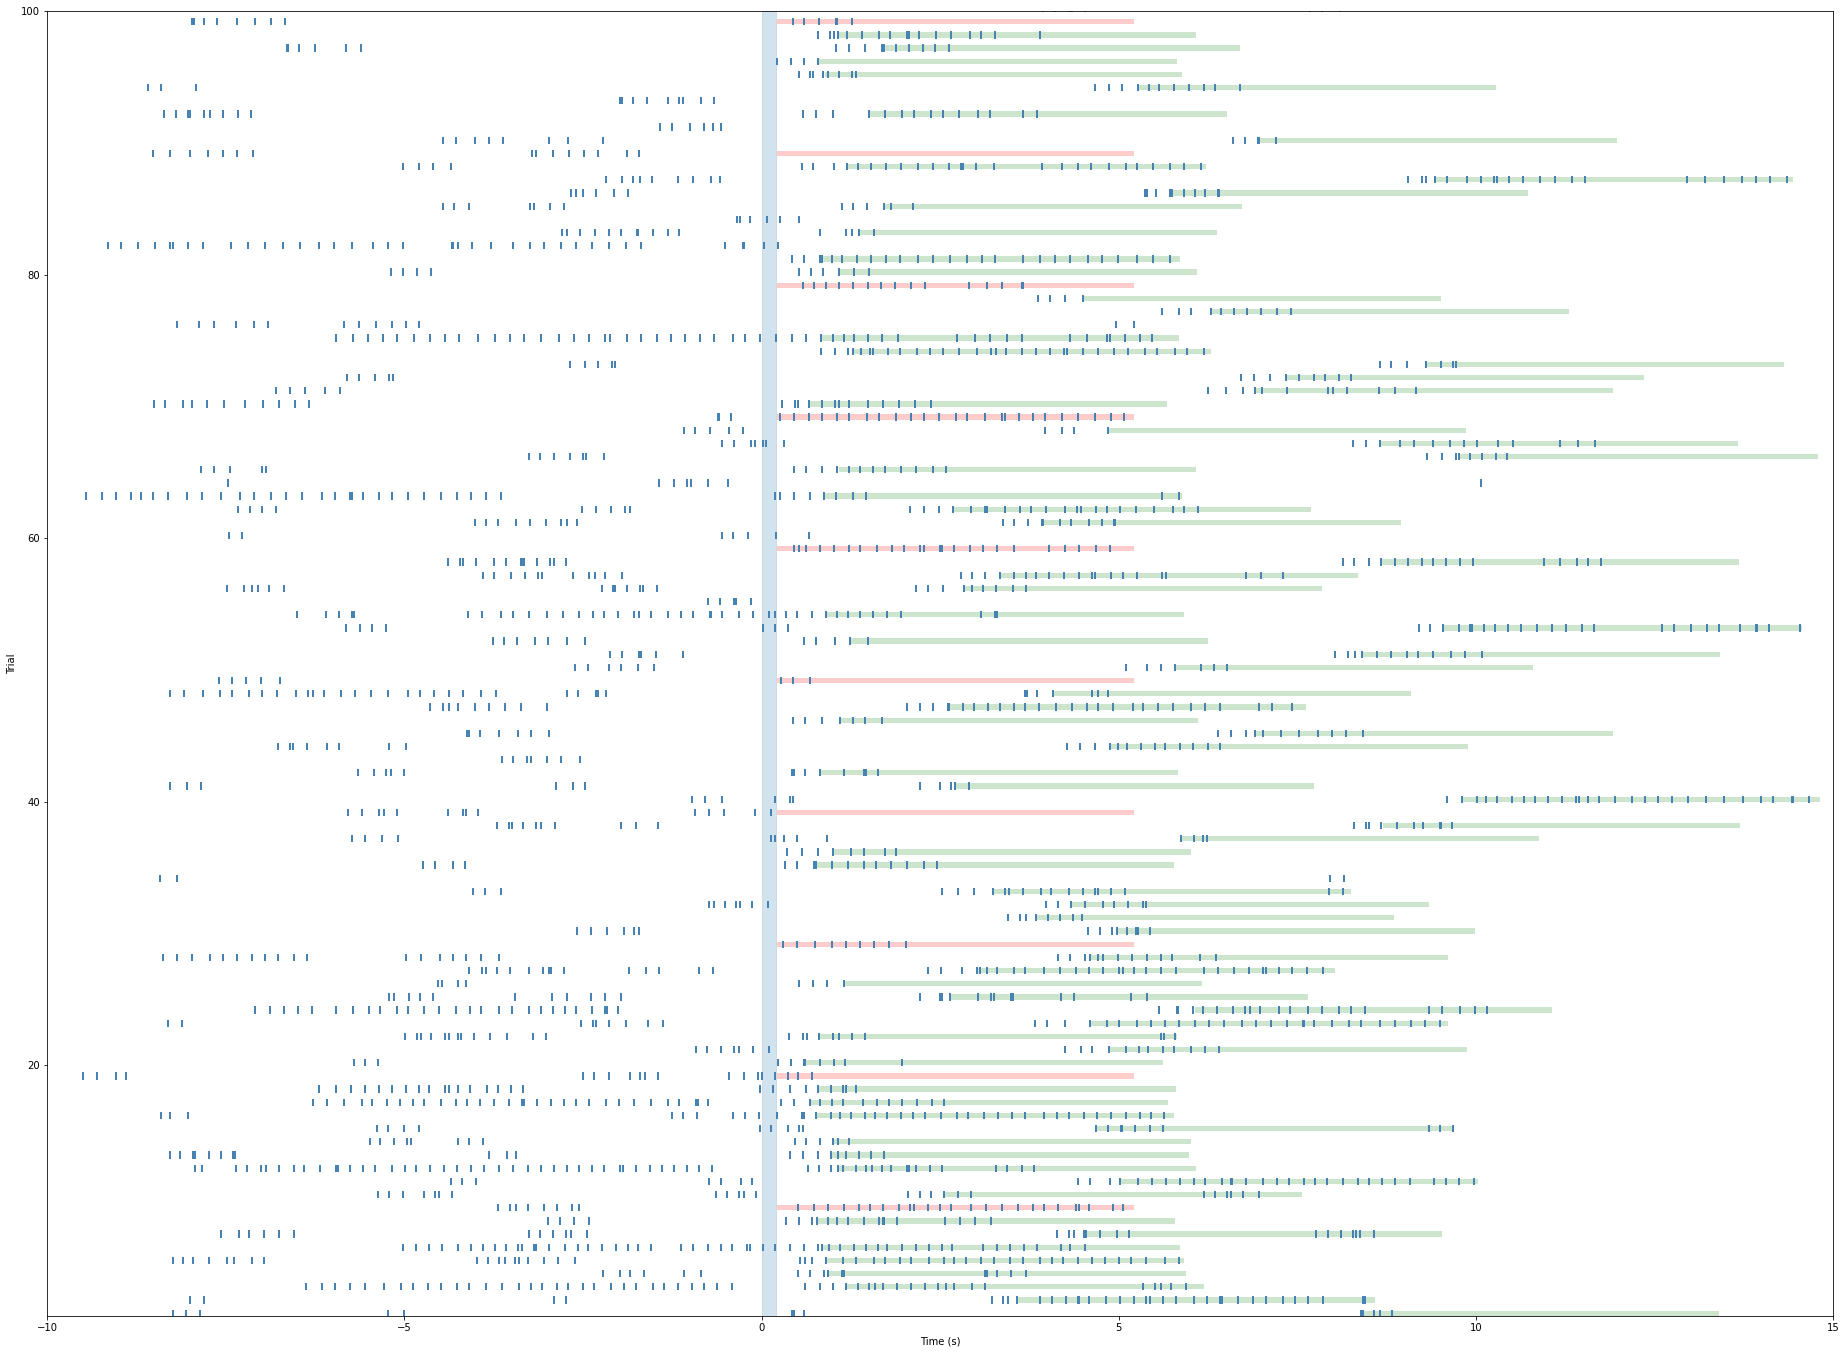

In [5]:
from matplotlib import cm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Define color map for drinking patches
drinking_cmap = cm.get_cmap('Set1')

lick_plots = []

fig = plt.figure(figsize=(32, 24))

# Define colors for plotting
edgecolor_cue = [0.5, 0.5, 0.5]  # use edgecolor instead of color for cue patch
color_lick = 'SteelBlue'

trials = SessionData["RawEvents"][0, 0]["Trial"]
states_list = [trial.item()[0, 0]["States"][0, 0] for trial in np.nditer(trials, flags=['refs_ok'])]
num_trials = SessionData['nTrials'][0, 0][0, 0]

# Plot Cue
cue_start = round(states_list[0]['Cue'][0][0][0][0], 2)
cue_duration = round(states_list[0]['Cue'][0][0][0][1] - states_list[0]['Cue'][0][0][0][0], 2)
x_points_cue = [cue_start, cue_start, cue_start + cue_duration, cue_start + cue_duration]
y_points_cue = [0, num_trials + 1, num_trials + 1, 0]
cue = plt.fill(x_points_cue, y_points_cue, edgecolor=edgecolor_cue, facecolor=None, alpha=0.2)

for trial in range(num_trials):
    licks = lickometer["BNCHigh"][trial]
    trial_lick_plots = []
    for lick_arr in licks:
        for lick in lick_arr:
            ylicks = np.array([trial, trial + 0.4, np.nan])
            xlicks = np.array([lick, lick, np.nan])
            plot = plt.plot(xlicks, ylicks, color=color_lick, linewidth=2)
            trial_lick_plots.append(plot)
    lick_plots.append(trial_lick_plots)

    # Get state information for current trial
    state_info = None
    if trial < len(trials.item()[0]):
        state_info = trials.item()[0, trial]["States"][0, 0]

    # Plot Drinking if state information is available for current trial
    if state_info is not None and "Drinking" in state_info.dtype.fields.keys():
        drinking_start = state_info["Drinking"][0][0][0][0]
        drinking_end = state_info["Drinking"][0][0][0][1]
        drinking_duration = drinking_end - drinking_start
        x_points_drinking = [drinking_start, drinking_start, drinking_start + drinking_duration, drinking_start + drinking_duration]
        y_points_drinking = [trial, trial + 0.4, trial + 0.4, trial]
    if "UnconditionedReward" in state_info.dtype.fields.keys() and not np.isnan(state_info["UnconditionedReward"][0][0][0]).any():
        drinking_color = 'red'
    else:
        drinking_color = 'green'
    path = Path(np.array([x_points_drinking, y_points_drinking]).T)
    drinking_patch = PathPatch(path, facecolor=drinking_color, linestyle="none", alpha=0.2)
    plt.gca().add_patch(drinking_patch)

y_height = num_trials + 1
plt.ylim([1, y_height])
plt.ylim([1, 100]) # limit ylim to be consistent across days
plt.xlim([-10, 15])
plt.ylabel("Trial")
plt.xlabel("Time (s)")

plt.show()